In [1]:
pip install yfinance scikit-learn keras matplotlib seaborn

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import datetime
import warnings
warnings.filterwarnings("ignore")

# Step 1: Data Collection

In [3]:
# Data Collection
infosys_data = yf.download('INFY.NS', start='2020-01-01', end=datetime.datetime.today())
infosys_data.reset_index(inplace=True)

[*********************100%***********************]  1 of 1 completed


In [4]:
infosys_data.head()

Price,Date,Close,High,Low,Open,Volume
Ticker,,INFY.NS,INFY.NS,INFY.NS,INFY.NS,INFY.NS
0,2020-01-01,646.518677,649.282536,642.745829,644.895492,2112415
1,2020-01-02,644.632263,649.984436,641.298120,648.317391,5658200
2,2020-01-03,654.547058,656.301876,643.930432,643.930432,7882938
3,2020-01-06,648.273621,661.390896,646.211731,654.634836,6519403
4,2020-01-07,638.665955,651.563822,636.209167,647.527763,7899363


In [5]:
infosys_data.tail()

Price,Date,Close,High,Low,Open,Volume
Ticker,,INFY.NS,INFY.NS,INFY.NS,INFY.NS,INFY.NS
1346,2025-06-10,1596.000000,1607.500000,1577.500000,1584.000000,8591925
1347,2025-06-11,1631.099976,1634.599976,1590.099976,1590.099976,10597410
1348,2025-06-12,1608.599976,1628.000000,1598.099976,1617.000000,10483574
1349,2025-06-13,1602.000000,1609.000000,1570.199951,1576.000000,6968315
1350,2025-06-16,1623.800049,1634.800049,1597.099976,1600.000000,5591842


# Step 2: Preprocessing

In [6]:
# Preprocessing
infosys_data['Date'] = pd.to_datetime(infosys_data['Date'])
infosys_data.sort_values('Date', inplace=True)
infosys_data['Daily Return'] = infosys_data['Close'].pct_change()
infosys_data['Price Change'] = infosys_data['Close'] - infosys_data['Open']
infosys_data.dropna(inplace=True)

# Step 3:Technical Indicators

Moving Averages

In [7]:
# Moving Averages
# Simple Moving Average
infosys_data['SMA_20'] = infosys_data['Close'].rolling(window=20).mean()

# Exponential Moving Average
infosys_data['EMA_20'] = infosys_data['Close'].ewm(span=20, adjust=False).mean()


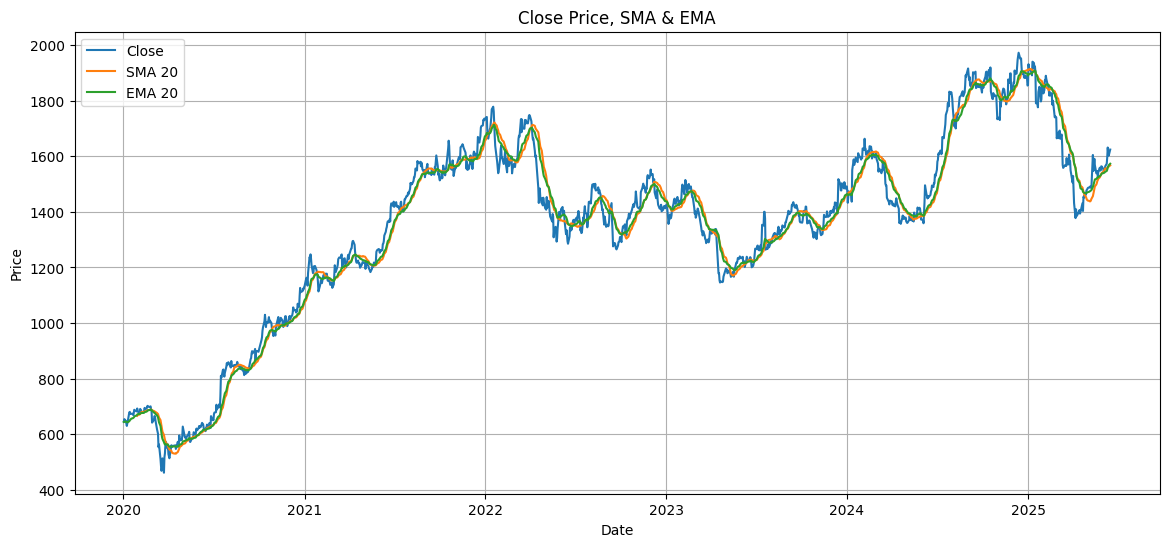

In [8]:
plt.figure(figsize=(14, 6))
plt.plot(infosys_data['Date'], infosys_data['Close'], label='Close')
plt.plot(infosys_data['Date'], infosys_data['SMA_20'], label='SMA 20')
plt.plot(infosys_data['Date'], infosys_data['EMA_20'], label='EMA 20')
plt.title('Close Price, SMA & EMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

RSI (Relative Strength Index)

In [9]:
# RSI
delta = infosys_data['Close'].diff()
gain = np.where(delta > 0, delta, 0)
loss = np.where(delta < 0, -delta, 0)
# Ensure gain and loss are 1-dimensional before creating Series
avg_gain = pd.Series(gain[:, 0]).rolling(window=14).mean()
avg_loss = pd.Series(loss[:, 0]).rolling(window=14).mean()
rs = avg_gain / avg_loss
infosys_data['RSI'] = 100 - (100 / (1 + rs))

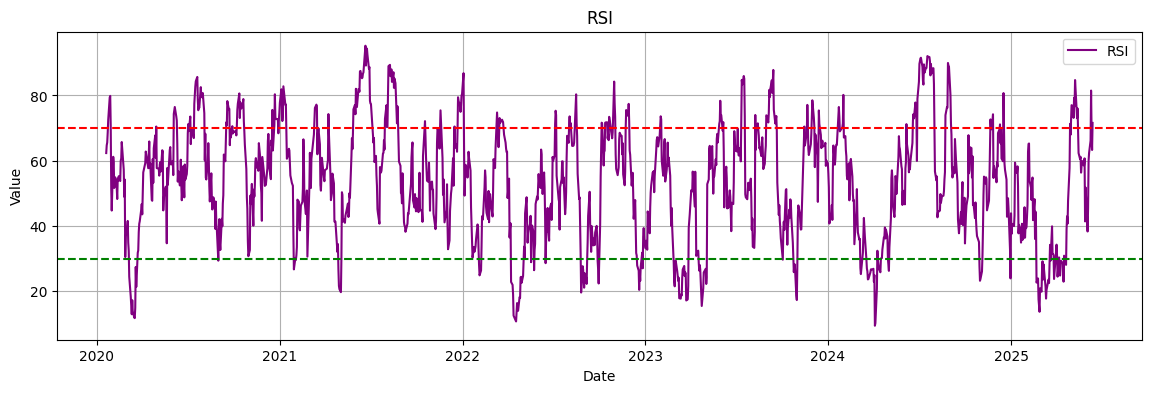

In [10]:
plt.figure(figsize=(14, 4))
plt.plot(infosys_data['Date'], infosys_data['RSI'], label='RSI', color='purple')
plt.axhline(70, linestyle='--', color='red'); plt.axhline(30, linestyle='--', color='green')
plt.title('RSI')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()


MACD (Moving Average Convergence Divergence)

In [11]:
# MACD
exp1 = infosys_data['Close'].ewm(span=12, adjust=False).mean()
exp2 = infosys_data['Close'].ewm(span=26, adjust=False).mean()
infosys_data['MACD'] = exp1 - exp2
infosys_data['MACD_Signal'] = infosys_data['MACD'].ewm(span=9, adjust=False).mean()
infosys_data['MACD_Hist'] = infosys_data['MACD'] - infosys_data['MACD_Signal']

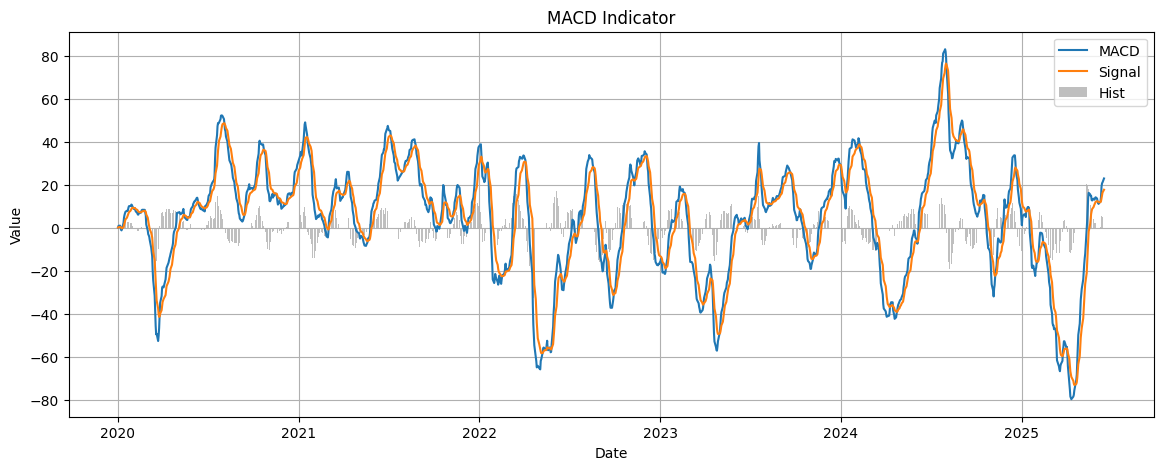

In [12]:
plt.figure(figsize=(14, 5))
plt.plot(infosys_data['Date'], infosys_data['MACD'], label='MACD')
plt.plot(infosys_data['Date'], infosys_data['MACD_Signal'], label='Signal')
plt.bar(infosys_data['Date'], infosys_data['MACD_Hist'], label='Hist', color='gray', alpha=0.5)
plt.title('MACD Indicator')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()

Bollinger Bands

In [13]:
# Bollinger Bands Calculation (Corrected)
infosys_data['BB_Middle'] = infosys_data['Close'].rolling(window=20).mean()
infosys_data['BB_Std'] = infosys_data['Close'].rolling(window=20).std()

infosys_data['BB_Upper'] = infosys_data['BB_Middle'] + 2 * infosys_data['BB_Std']
infosys_data['BB_Lower'] = infosys_data['BB_Middle'] - 2 * infosys_data['BB_Std']


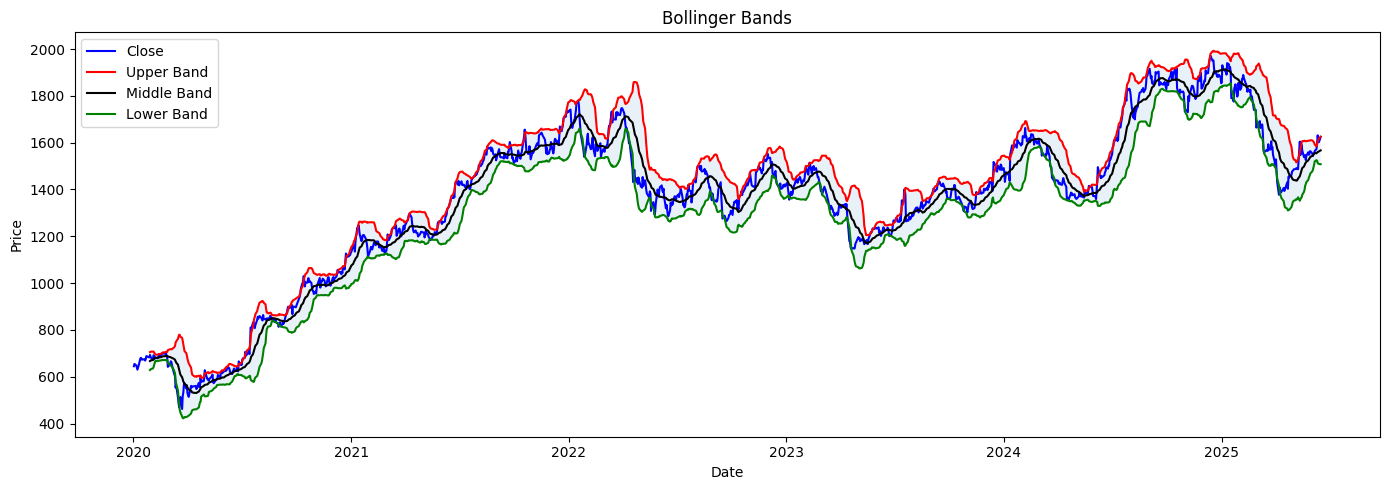

In [14]:
# Bollinger Bands
plt.figure(figsize=(14, 5))
plt.plot(infosys_data['Date'], infosys_data['Close'], label='Close', color='blue')
plt.plot(infosys_data['Date'], infosys_data['BB_Upper'], label='Upper Band', color='red')
plt.plot(infosys_data['Date'], infosys_data['BB_Middle'], label='Middle Band', color='black')
plt.plot(infosys_data['Date'], infosys_data['BB_Lower'], label='Lower Band', color='green')
plt.fill_between(infosys_data['Date'], infosys_data['BB_Lower'], infosys_data['BB_Upper'], alpha=0.1)
plt.title('Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

ATR (Average True Range)

In [15]:
# ATR
high_low = infosys_data['High'] - infosys_data['Low']
high_close = np.abs(infosys_data['High'] - infosys_data['Close'].shift())
low_close = np.abs(infosys_data['Low'] - infosys_data['Close'].shift())
true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
infosys_data['ATR_14'] = true_range.rolling(14).mean()



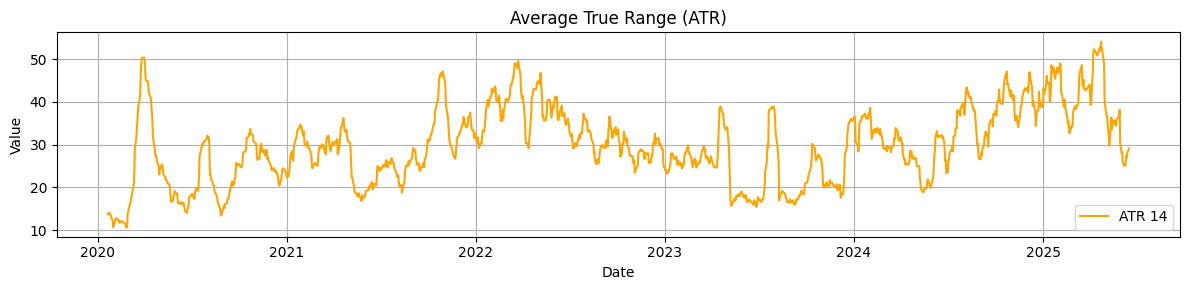

In [16]:
# ATR
plt.figure(figsize=(12, 3))
plt.plot(infosys_data['Date'], infosys_data['ATR_14'], label='ATR 14', color='orange')
plt.title('Average True Range (ATR)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [17]:
# Display processed data
print(infosys_data.tail())

Price        Date        Close         High          Low         Open  \
Ticker                 INFY.NS      INFY.NS      INFY.NS      INFY.NS   
1346   2025-06-10  1596.000000  1607.500000  1577.500000  1584.000000   
1347   2025-06-11  1631.099976  1634.599976  1590.099976  1590.099976   
1348   2025-06-12  1608.599976  1628.000000  1598.099976  1617.000000   
1349   2025-06-13  1602.000000  1609.000000  1570.199951  1576.000000   
1350   2025-06-16  1623.800049  1634.800049  1597.099976  1600.000000   

Price     Volume Daily Return Price Change       SMA_20       EMA_20  \
Ticker   INFY.NS                                                       
1346     8591925     0.014686    12.000000  1556.995105  1551.474151   
1347    10597410     0.021992    41.000000  1560.034821  1559.057562   
1348    10483574    -0.013794    -8.400024  1560.933832  1563.775888   
1349     6968315    -0.004103    26.000000  1562.641815  1567.416279   
1350     5591842     0.013608    23.800049  1566.923920 

Volume-Price Relationship

In [18]:
# Volume-Price Relationship
infosys_data['Volume_Change'] = infosys_data['Volume'].pct_change()
volume_price_corr = infosys_data[['Volume', 'Price Change']].corr().iloc[0, 1]

# Prepare Data for LSTM

# LSTM Price Prediction

In [19]:
# LSTM Model
scaler = MinMaxScaler()
scaled_close = scaler.fit_transform(infosys_data[['Close']])
X, y = [], []
look_back = 60
for i in range(look_back, len(scaled_close)):
    X.append(scaled_close[i - look_back:i, 0])
    y.append(scaled_close[i, 0])
X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [20]:
# Train-Test Split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build LSTM model

In [21]:
# Model Definition
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Train model

In [22]:
# Train model
model.fit(X, y, epochs=10, batch_size=32, validation_split=0.2, callbacks=[EarlyStopping(patience=3)])
# Predict on test data
predicted = model.predict(X)
predicted_prices = scaler.inverse_transform(predicted)
actual_prices = scaler.inverse_transform(y.reshape(-1, 1))

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 84ms/step - loss: 0.0960 - val_loss: 0.0019
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 0.0024 - val_loss: 0.0038
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0010 - val_loss: 0.0020
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


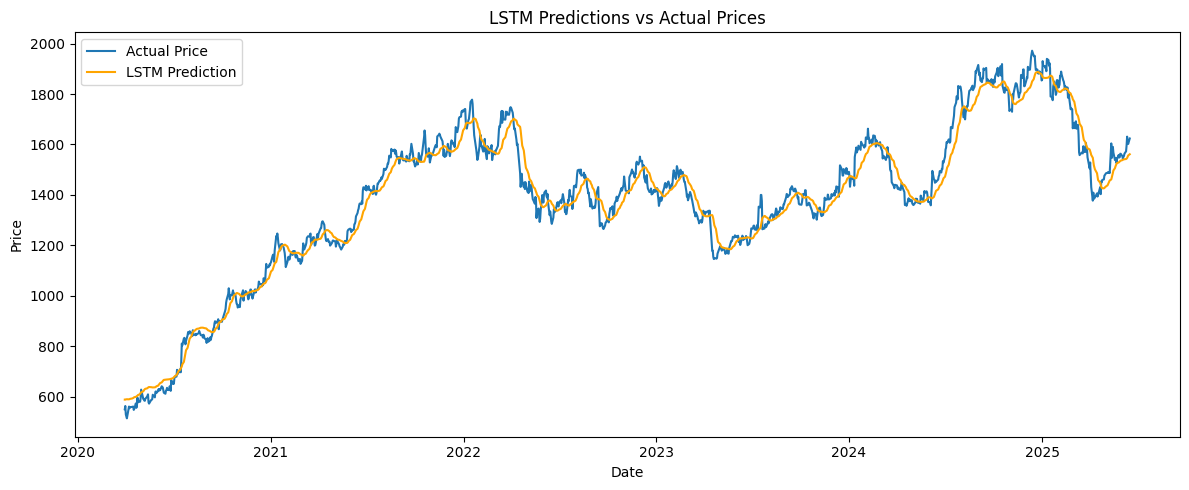

In [23]:
# LSTM Historical Predictions
plt.figure(figsize=(12, 5))
plt.plot(infosys_data['Date'][-len(predicted_prices):], infosys_data['Close'].values[-len(predicted_prices):], label='Actual Price')
plt.plot(infosys_data['Date'][-len(predicted_prices):], predicted_prices, label='LSTM Prediction', color='orange')
plt.title('LSTM Predictions vs Actual Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

# Anomaly Detection

In [24]:
# Anomaly Detection
features = infosys_data[['Close', 'Volume', 'Price Change', 'RSI']].dropna()
iso_forest = IsolationForest(contamination=0.01, random_state=42)
infosys_data.loc[features.index, 'Anomaly'] = iso_forest.fit_predict(features)
infosys_data['Anomaly'] = infosys_data['Anomaly'].map({1: 0, -1: 1})

Visualize Anomalies Separately

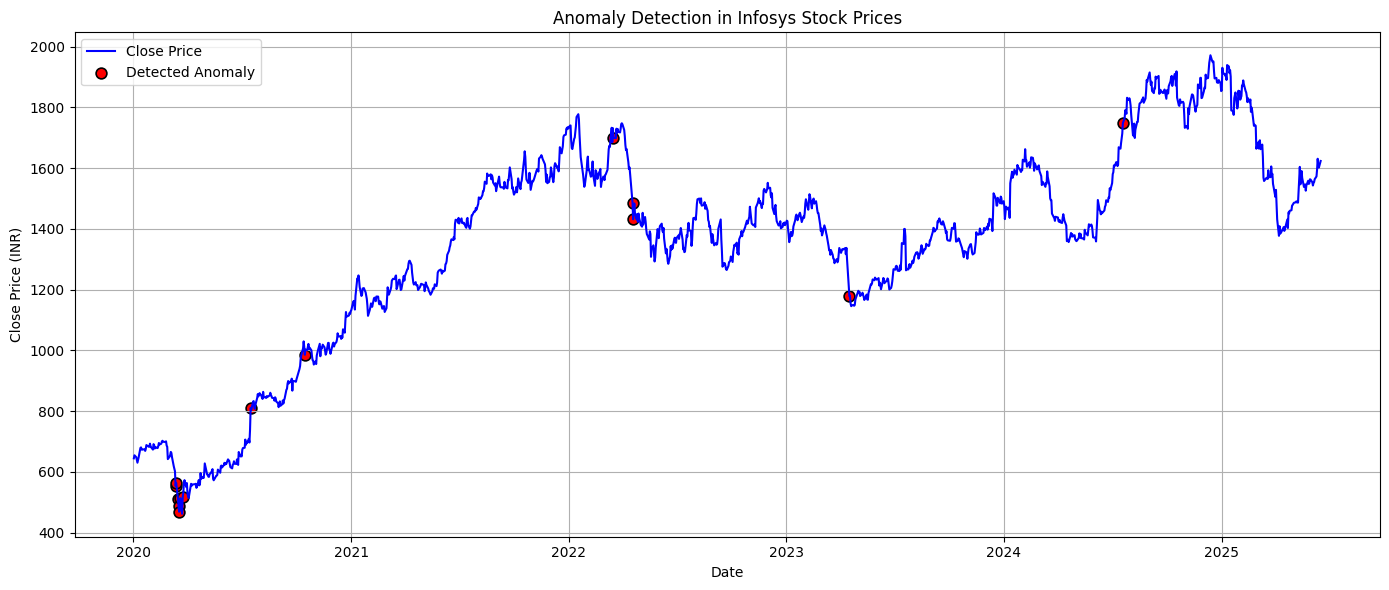

In [25]:
plt.figure(figsize=(14, 6))
plt.plot(infosys_data['Date'], infosys_data['Close'], label='Close Price', color='blue')
plt.scatter(
    infosys_data[infosys_data['Anomaly'] == 1]['Date'],
    infosys_data[infosys_data['Anomaly'] == 1]['Close'],
    color='red',
    label='Detected Anomaly',
    s=60,
    edgecolors='black',
    linewidth=1.2
)
plt.title('Anomaly Detection in Infosys Stock Prices')
plt.xlabel('Date')
plt.ylabel('Close Price (INR)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Future Forecast

In [26]:
# Future Forecast
def predict_future_prices(model, last_sequence, n_days, scaler):
    future_predictions = []
    current_seq = last_sequence.copy()
    for _ in range(n_days):
        # Predict the next step
        pred = model.predict(current_seq.reshape(1, look_back, 1), verbose=0)
        future_predictions.append(pred[0, 0])
        # Update the sequence for the next prediction
        current_seq = np.append(current_seq[1:], pred[0, 0])
    # Inverse transform the scaled predictions
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
    return future_predictions.flatten()

n_future_days = 30
# Use the correctly defined scaled_close variable
last_60_days = scaled_close[-look_back:]
future_prices = predict_future_prices(model, last_60_days, n_future_days, scaler)
# Generate future dates, excluding weekends
future_dates = pd.date_range(start=infosys_data['Date'].iloc[-1] + pd.Timedelta(days=1), periods=n_future_days, freq='B')
future_df = pd.DataFrame({'Date': future_dates, 'Predicted_Close': future_prices})

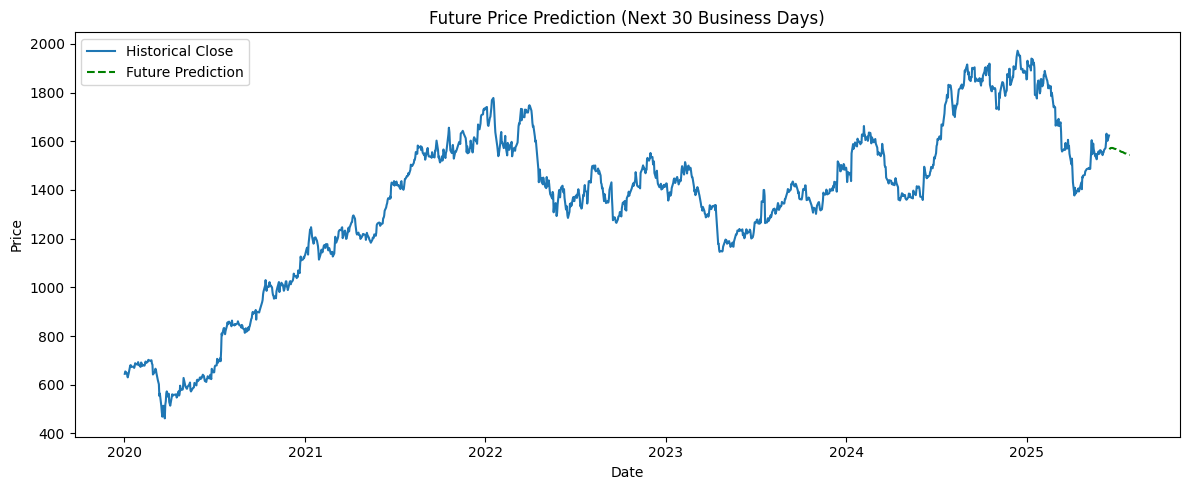

In [27]:
# Future Forecast Plot
plt.figure(figsize=(12, 5))
plt.plot(infosys_data['Date'], infosys_data['Close'], label='Historical Close')
plt.plot(future_df['Date'], future_df['Predicted_Close'], label='Future Prediction', linestyle='--', color='green')
plt.title('Future Price Prediction (Next 30 Business Days)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

In [28]:
# Random Dates from Future
random_indices = np.random.choice(range(n_future_days), size=5, replace=False)
random_preds = future_df.iloc[random_indices].sort_values('Date')
print("\n Sample Future Predictions on Random Dates:")
print(random_preds.to_string(index=False))


 Sample Future Predictions on Random Dates:
      Date  Predicted_Close
2025-07-02      1565.520508
2025-07-15      1554.169434
2025-07-16      1552.941406
2025-07-22      1548.103760
2025-07-25      1544.552856


In [29]:
# Step 7: Export to CSV
infosys_data.to_csv('infosys_cleaned_data.csv', index=False)
future_df.to_csv('infosys_future_predictions.csv', index=False)

# Summary Report
print("\n Summary Report:")
# Correct the variable name from volume_corr to volume_price_corr
print(f"- Volume-Price Correlation: {volume_price_corr:.4f}")
print(f"- Total Anomalies Detected: {int(infosys_data['Anomaly'].sum())}")
# Access the scalar value using .item() before formatting
print(f"- Latest Close Price: ₹{infosys_data['Close'].iloc[-1].item():.2f}")
print("- Cleaned data saved to 'infosys_cleaned_data.csv'")
print("- Future predictions saved to 'infosys_future_predictions.csv'")


 Summary Report:
- Volume-Price Correlation: 0.0467
- Total Anomalies Detected: 14
- Latest Close Price: ₹1623.80
- Cleaned data saved to 'infosys_cleaned_data.csv'
- Future predictions saved to 'infosys_future_predictions.csv'


In [30]:
from google.colab import files
files.download('infosys_cleaned_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>